<h1 align="center"><u>MACHINE LEARNING 1 - BIA-5302-0LB</u></h1>
<h1 align="center"><u>FINAL PROJECT - GROUP 02</u></h1>
<h1 align="center"><u>TELCO CUSTOMER CHURN PREDICTION & PREVENTION ANALYSIS</u></h1>

<p align="center">
<strong>Project Description</strong>:<br>
This end-to-end data science project analyzes customer churn patterns for a telecommunications company. Using machine learning (Logistic Regression, Random Forest, Decision Trees), it identifies at-risk customers by examining service usage, contract terms, and payment behaviors.<br>

## **<u>Importing Libraries<u>**

In [71]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (accuracy_score, classification_report, 
                            confusion_matrix, roc_curve, roc_auc_score,
                            precision_recall_curve, average_precision_score)

import warnings
warnings.filterwarnings("ignore")

In [72]:
# Set style for plots
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

## **<u>Loading Dataset<u>**

In [73]:
df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')
print("Dataset loaded successfully with shape:", df.shape)

Dataset loaded successfully with shape: (7043, 21)


In [74]:
print("\nFirst 5 rows of the dataset:")
print(df.head())


First 5 rows of the dataset:
   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport StreamingTV Stream

## **<u>Data Cleaning & Preprocessing<u>**

In [75]:
# Check for missing values
print("\nMissing values before cleaning:")
print(df.isnull().sum())


Missing values before cleaning:
customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64


In [76]:
# Handle missing values in TotalCharges (convert to numeric and fill NA)
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['TotalCharges'].fillna(df['TotalCharges'].median(), inplace=True)

In [77]:
# Check for duplicates
print("\nNumber of duplicate rows:", df.duplicated().sum())


Number of duplicate rows: 0


In [78]:
# Drop customerID as it's not useful for modeling
df.drop('customerID', axis=1, inplace=True)

## **<u>Exploratory Data Analysis<u>**

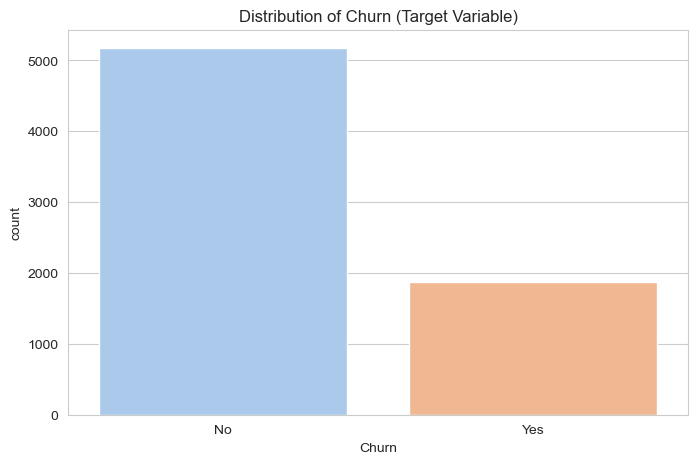


Churn Percentage:
Churn
No     73.463013
Yes    26.536987
Name: proportion, dtype: float64


In [79]:
# Target Variable Distribution
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='Churn', palette='pastel')
plt.title('Distribution of Churn (Target Variable)')
plt.show()

churn_percentage = df['Churn'].value_counts(normalize=True) * 100
print(f"\nChurn Percentage:\n{churn_percentage}")



Summary statistics for numerical features:
            tenure  MonthlyCharges  TotalCharges
count  7043.000000     7043.000000   7043.000000
mean     32.371149       64.761692   2281.916928
std      24.559481       30.090047   2265.270398
min       0.000000       18.250000     18.800000
25%       9.000000       35.500000    402.225000
50%      29.000000       70.350000   1397.475000
75%      55.000000       89.850000   3786.600000
max      72.000000      118.750000   8684.800000


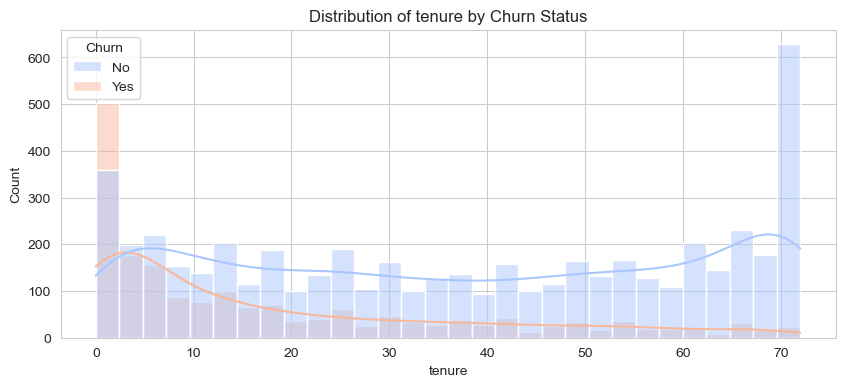

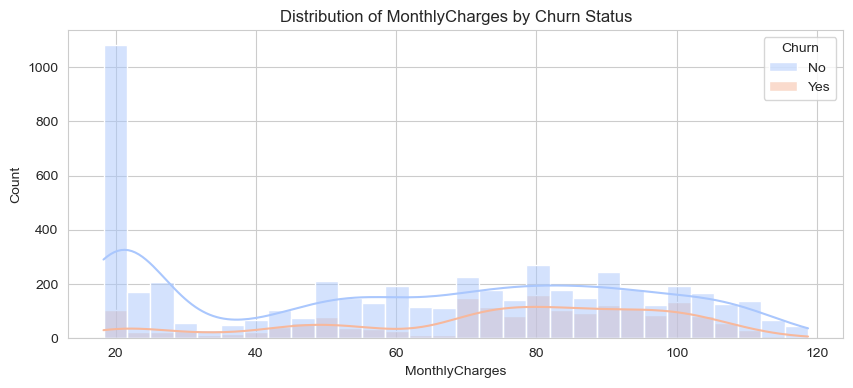

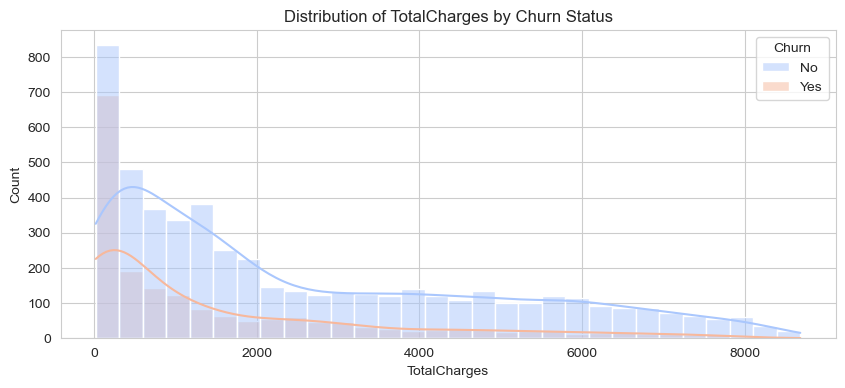

In [80]:
# Numerical Features Analysis
num_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']
print("\nSummary statistics for numerical features:")
print(df[num_cols].describe())

# Distribution plots for numerical features
for col in num_cols:
    plt.figure(figsize=(10, 4))
    sns.histplot(data=df, x=col, hue='Churn', kde=True, bins=30, palette='coolwarm')
    plt.title(f'Distribution of {col} by Churn Status')
    plt.show()

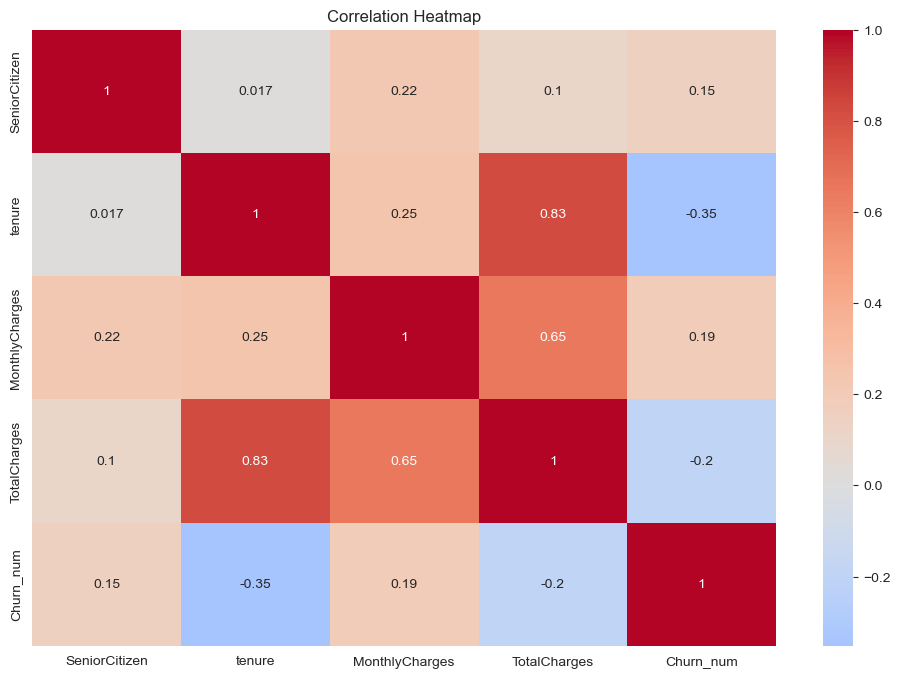

In [81]:
# Correlation Analysis
# Convert target to numeric for correlation
df['Churn_num'] = df['Churn'].map({'Yes': 1, 'No': 0})

# Correlation heatmap
plt.figure(figsize=(12, 8))
corr_matrix = df.corr(numeric_only=True)
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Heatmap')
plt.show()

## **<u>Feature Engineering<u>**

In [82]:
# Convert binary categorical features to 0/1
binary_cols = ['Partner', 'Dependents', 'PhoneService', 'PaperlessBilling']
for col in binary_cols:
    df[col] = df[col].map({'Yes': 1, 'No': 0})

# Convert gender to binary
df['gender'] = df['gender'].map({'Female': 0, 'Male': 1})

# Handle special cases in MultipleLines and other services
service_cols = ['MultipleLines', 'OnlineSecurity', 'OnlineBackup', 
               'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']

for col in service_cols:
    df[col] = df[col].replace({'No phone service': 'No', 'No internet service': 'No'})
    df[col] = df[col].map({'Yes': 1, 'No': 0})

In [83]:
# Create new features
# Tenure groups
df['TenureGroup'] = pd.cut(df['tenure'], bins=[0, 12, 24, 48, 72, np.inf],
                          labels=['0-1yr', '1-2yr', '2-4yr', '4-6yr', '6+yr'])

# Monthly charge categories
df['MonthlyChargeGroup'] = pd.cut(df['MonthlyCharges'], bins=[0, 35, 70, 90, np.inf],
                                 labels=['Low', 'Medium', 'High', 'Very High'])

In [84]:
# One-Hot Encoding for remaining categorical features
df = pd.get_dummies(df, columns=['InternetService', 'Contract', 'PaymentMethod', 
                                'TenureGroup', 'MonthlyChargeGroup'], drop_first=True)

In [85]:
# Remove the temporary Churn numeric column
df.drop('Churn_num', axis=1, inplace=True)

In [86]:
# Convert target to binary
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

## **<u>Outlier Detection & Treatment<u>**

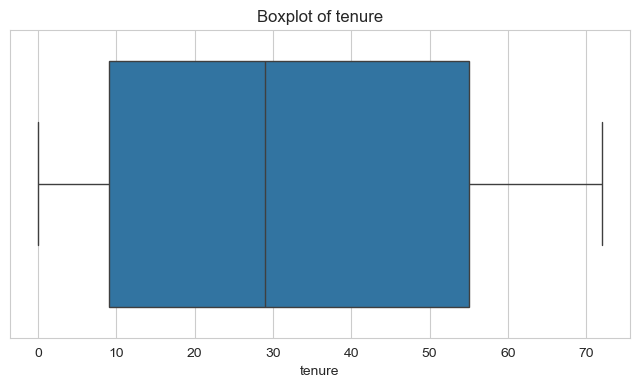

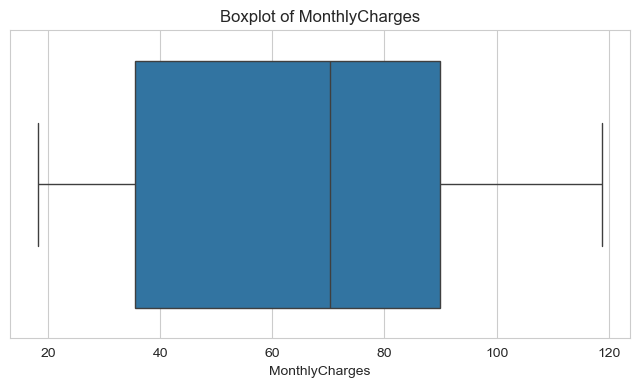

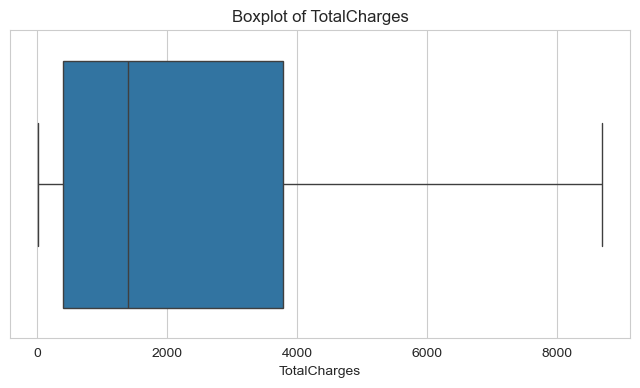

In [87]:
# Boxplot visualization before outlier treatment
for col in num_cols:
    plt.figure(figsize=(8, 4))
    sns.boxplot(data=df, x=col)
    plt.title(f'Boxplot of {col}')
    plt.show()


In [88]:
# IQR method for outlier treatment
for col in num_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Cap the outliers
    df[col] = np.where(df[col] < lower_bound, lower_bound, df[col])
    df[col] = np.where(df[col] > upper_bound, upper_bound, df[col])

## **<u>Machine Learning Modeling<u>**

In [89]:
# Prepare data
X = df.drop('Churn', axis=1)
y = df['Churn']

In [90]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, 
                                                  stratify=y, random_state=42)


In [91]:
# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [92]:
# Initialize models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Naive Bayes": GaussianNB(),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "K-Nearest Neighbors": KNeighborsClassifier()
}

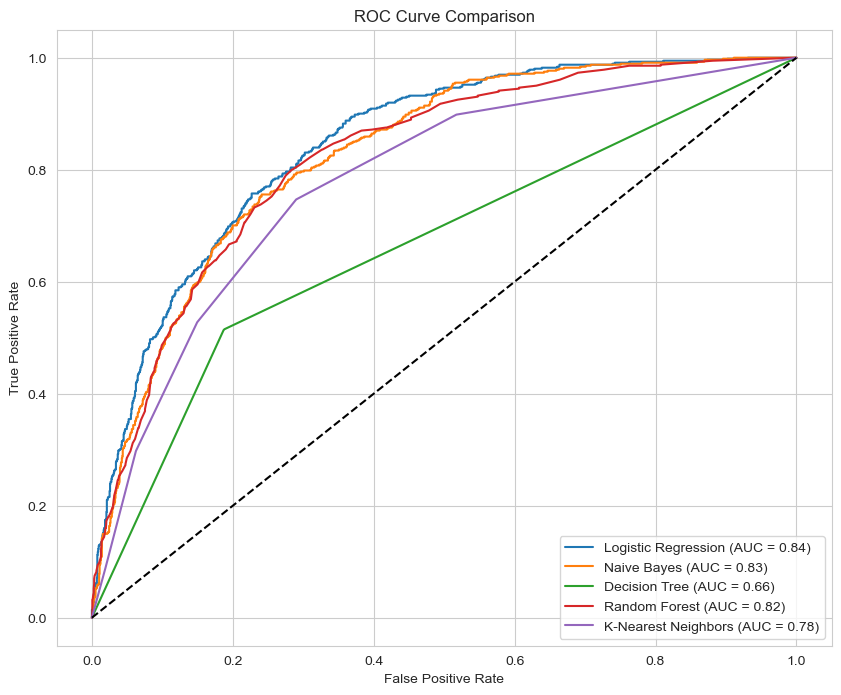

In [93]:
# Train and evaluate models
results = {}
plt.figure(figsize=(10, 8))

for name, model in models.items():
    # Train model
    model.fit(X_train_scaled, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test_scaled)
    y_prob = model.predict_proba(X_test_scaled)[:, 1]
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)
    precision = average_precision_score(y_test, y_prob)
    
    # Classification report
    report = classification_report(y_test, y_pred, output_dict=True)
    
    # Store results
    results[name] = {
        'Accuracy': accuracy,
        'AUC': auc,
        'Precision': precision,
        'Recall': report['1']['recall'],
        'F1-Score': report['1']['f1-score']
    }
    
    # Plot ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc:.2f})')

# Plot the random guess line
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.show()

In [94]:
# Display results
results_df = pd.DataFrame(results).T
print("\nModel Performance Comparison:")
print(results_df)


Model Performance Comparison:
                     Accuracy       AUC  Precision    Recall  F1-Score
Logistic Regression  0.799337  0.844593   0.643653  0.520499  0.579365
Naive Bayes          0.749645  0.828210   0.603180  0.755793  0.615832
Decision Tree        0.733554  0.663668   0.385410  0.513369  0.505707
Random Forest        0.790819  0.821955   0.609223  0.486631  0.552632
K-Nearest Neighbors  0.764789  0.779810   0.507659  0.527629  0.543618


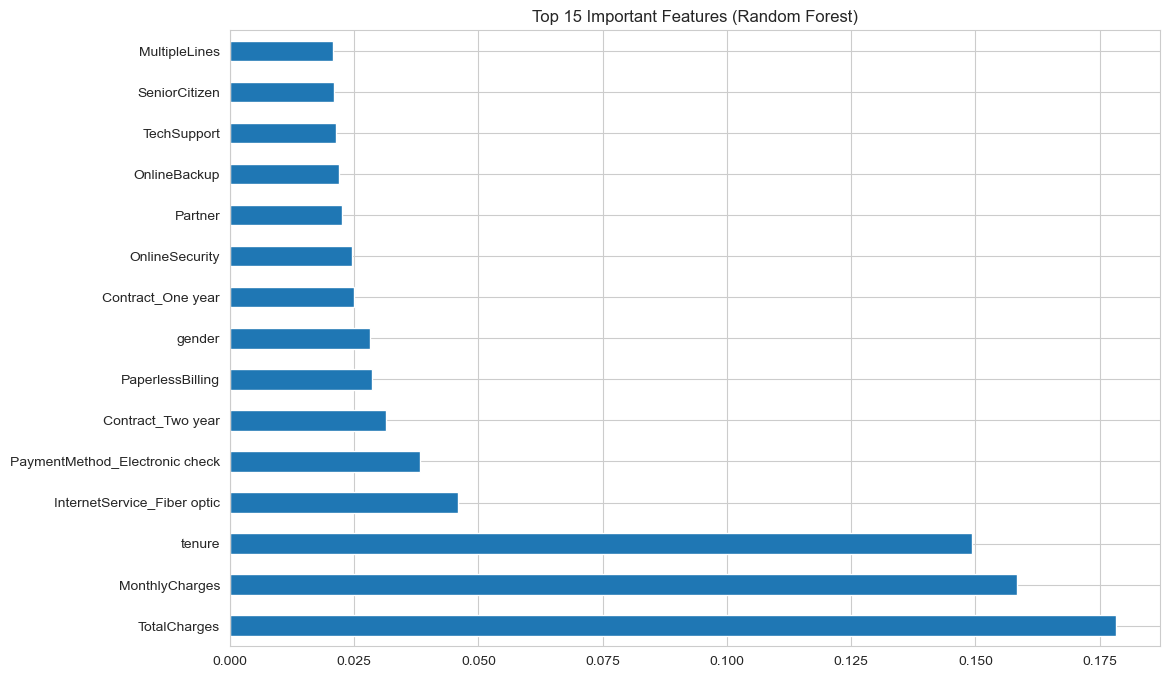

In [95]:
# Feature Importance (for tree-based models)
plt.figure(figsize=(12, 8))
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_scaled, y_train)
importances = pd.Series(rf.feature_importances_, index=X.columns)
importances.nlargest(15).plot(kind='barh')
plt.title('Top 15 Important Features (Random Forest)')
plt.show()

## **<u>Precision-Recall Curve<u>**

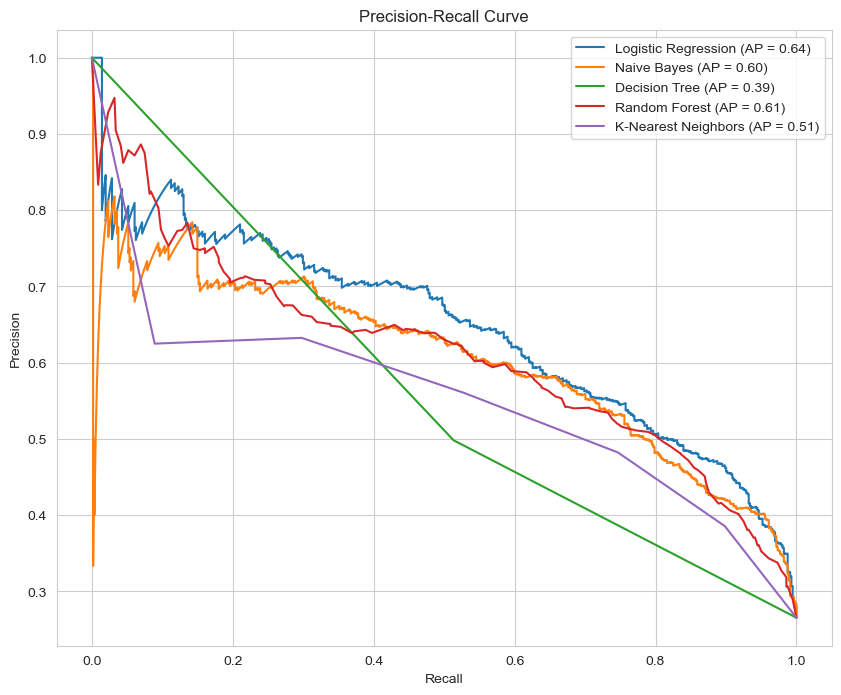

In [96]:
plt.figure(figsize=(10, 8))
for name, model in models.items():
    y_prob = model.predict_proba(X_test_scaled)[:, 1]
    precision, recall, _ = precision_recall_curve(y_test, y_prob)
    avg_precision = average_precision_score(y_test, y_prob)
    plt.plot(recall, precision, label=f'{name} (AP = {avg_precision:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

## **<u>Detailed Model Evaluation<u>**


Logistic Regression Evaluation


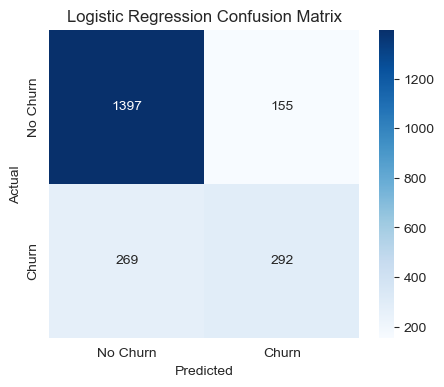


Classification Report:
              precision    recall  f1-score   support

    No Churn       0.84      0.90      0.87      1552
       Churn       0.65      0.52      0.58       561

    accuracy                           0.80      2113
   macro avg       0.75      0.71      0.72      2113
weighted avg       0.79      0.80      0.79      2113


Random Forest Evaluation


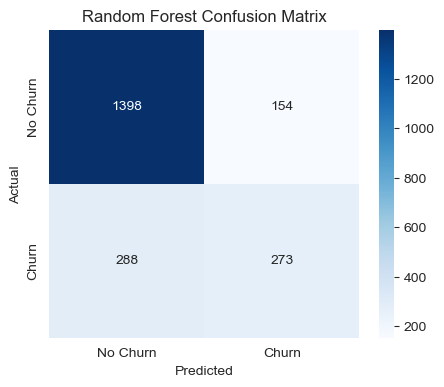


Classification Report:
              precision    recall  f1-score   support

    No Churn       0.83      0.90      0.86      1552
       Churn       0.64      0.49      0.55       561

    accuracy                           0.79      2113
   macro avg       0.73      0.69      0.71      2113
weighted avg       0.78      0.79      0.78      2113



In [97]:
# Select key models for detailed evaluation
key_models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42)
}

# Evaluate each key model
for model_name, model in key_models.items():
    print(f"\n{'='*50}")
    print(f"{model_name} Evaluation")
    print(f"{'='*50}")
    
    # Train model
    model.fit(X_train_scaled, y_train)
    
    # Predictions
    y_pred = model.predict(X_test_scaled)
    y_prob = model.predict_proba(X_test_scaled)[:, 1]
    
    # 1. Confusion Matrix
    plt.figure(figsize=(5, 4))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['No Churn', 'Churn'],
                yticklabels=['No Churn', 'Churn'])
    plt.title(f'{model_name} Confusion Matrix')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()
    
    # 2. Classification Report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=['No Churn', 'Churn']))
    

In [ ]:
graph TD
    A[Start: Import Telco Churn Dataset] --> B[Data Cleaning]
    B --> C[Handle Missing Values<br>(TotalCharges)]
    C --> D[Remove Irrelevant Columns<br>(e.g., customerID)]
    D --> E[Encode Categorical Variables]
    E --> F[Detect & Treat Outliers]
    F --> G[Feature Scaling<br>(StandardScaler)]
    G --> H[Split Data: Train (70%) / Test (30%)]
    H --> I[Train ML Models<br>(LogReg, RF, DT, NB, KNN)]
    I --> J[Evaluate Models<br>(Accuracy, AUC, F1, etc.)]
    J --> K[Generate Visuals<br>(ROC, PR Curve, Confusion Matrix)]
    K --> L[Interpret Results & Recommend Actions]
    L --> M[End]